# Simulating Wireless Network Using NS2 and Python for Analysis

<h3>
    Mohammad Taha Fakharian-810198449<br>
    Kianoush Arshi-810198438
</h3>

<h4>
    In this project, we simulate a wireless network using NS2.<br>
    We tested the network under different conditions, our variables are:<br>
        <li> Bandwidth
        <li> Error Rate
        <li> Packet Size<br>
    In order to execute the project, we refer you to the ReadME file.<br>
</h4>

## Table of Contents

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

import re
import os

In [17]:
FILE = 'wireless'
TOTAL_TIME = 100

## Logging in NS2

<h4>
    NS2 simulator stores the network logging in a ".tr" file.<br>
    There are different formatting for the logs. The formatting of wireless network logs using AODV protocol and UDP agents is explained in references [1] and [2].
</h4>

In [18]:
def get_logs(file_name=FILE+'.tr'):
    with open(file_name, 'r') as trace:
        logs = [re.split(' |\t', line.strip()) for line in trace]
    return logs

## Nodes in NS2

<h4>
    There are 9 nodes in the network, nodes A(0) and D(3) are the senders and nodes H(7) and I*(8) are recievers.<br>
    Node A sends it's packets to L and node D sends to H.<br>
    Based on the logging format of the trace file, nodes are mapped to values 0 to 8 alphabetically.<br>
    In order to find recievers and senders of a packet, and ignore the forwarding nodes, we must check their packet type (more explanation needed). If their type is "cbr", this log is the original send/recieve. If the abbreviation is "r", it's a recieve and if it's "s", a send.
</h4>

<h5>
    *Node I is named as L in the schematic.
</h5>

In [19]:
def make_node(node):
    return '_' + str(ord(node) - ord('A')) + '_'

def is_destination_recieve(log):
    return log[0] == 'r' and (log[2] == make_node('H') or log[2] == make_node('I')) and log[3] == 'AGT' and log[7] == 'cbr'

def is_source_send(log):
    return log[0] == 's' and (log[2] == make_node('A') or log[2] == make_node('D')) and log[3] == 'AGT' and log[7] == 'cbr'

## Throughput

<h4>
    Throughput is calculated using the following formula[3]:<br>
    TODO
    
</h4>

In [20]:
def calculate_throughput(logs, packet_size):
    recieves = 0
    for log in logs:
        if is_destination_recieve(log):
            recieves += 1
    return packet_size * recieves / TOTAL_TIME

## PTR(Packet Transfer Rate)

<h4>
    PTR is calculated using the following formula[3]:<br>
    
</h4>

In [21]:
def calculate_PTR(logs):
    recieves = 0
    sends = 0
    for log in logs:
        if is_destination_recieve(log):
            recieves += 1
        elif is_source_send(log):
            sends += 1
    return recieves / sends

## Average End-to-End Delay

<h4>
    Average End-to-End Delay is calculated using the following formula[3]:<br>

</h4>

In [22]:
def calculate_delay(logs):
    delay = 0
    recieves = 0
    start_time = {}
    for log in logs:
        if is_destination_recieve(log):
            delay += float(log[1]) - start_time[log[6]]
            recieves += 1
        elif is_source_send(log):
            start_time[log[6]] = float(log[1])
    return delay / recieves

In [23]:
def prepare_cmd(initial_cmd, bandwidth, error_rate, packet_size):
    """
        This function appends the arguments to the initial ns command.
    """
    
    initial_cmd += str(bandwidth) + 'Mb '
    initial_cmd += str(error_rate) + ' '
    initial_cmd += str(packet_size) + 'Kb'
    return initial_cmd

In [24]:
def delete_outputs(file=FILE):
    """
        This function deletes the generated nam and trace files.
    """
    if os.path.exists(file+'.nam'):
        os.remove(file+'.nam')
    if os.path.exists(file+'.tr'):
        os.remove(file+'.tr')

In [25]:
results = pd.DataFrame(columns = ['Bandwidth(Mb/s)', 'Error Rate', 'Packet Size(Kb)', 'Throughput', 'PTR', 'Average End-To-End Delay'])
results = results.set_index(['Bandwidth(Mb/s)', 'Error Rate', 'Packet Size(Kb)'])

## Simulating the Network

<h4>
The network is simulated with 3 different bandwidths, 10 different error rates from 0.0001 to 0.001* and 3 different packet sizes.<br>
</h4>

<h5>
    *The error rates of the project description were between 0.00001 and 0.000001, but these rates were too low to have any change of significant value.
</h5>

In [26]:
def run(tcl=FILE+'.tcl'):
    global results
    bandwidths = np.array([1.5, 15, 55])
    error_rates = np.linspace(0.0001, 0.001, 10)
    packet_sizes = np.array([64, 256, 512])
    initial_cmd = 'ns ' + tcl + ' '
    for bandwidth, error_rate, packet_size in it.product(bandwidths, error_rates, packet_sizes):
        cmd = prepare_cmd(initial_cmd, bandwidth, error_rate, packet_size)
        print(cmd)
        print("----------------------------------------------")
        cmd += ' >/dev/null 2>&1'
        os.system(cmd)
        
        logs = get_logs()
        throughput = calculate_throughput(logs, packet_size)
        PTR = calculate_PTR(logs)
        delay = calculate_delay(logs)
        results.loc[bandwidth, error_rate, packet_size] = [throughput, PTR, delay]
        
        delete_outputs()

In [27]:
run()

ns wireless.tcl 1.5Mb 0.0001 64Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.0001 256Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.0001 512Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.00019999999999999998 64Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.00019999999999999998 256Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.00019999999999999998 512Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.0003 64Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.0003 256Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.0003 512Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.00039999999999999996 64Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 0.00039999999999999996 256Kb
----------------------------------------------
ns wireless.tcl 1.5Mb 

In [28]:
results

Throughput       PTR  \
Bandwidth(Mb/s) Error Rate Packet Size(Kb)                         
1.5             0.0001     64                  8752.64  0.175226   
                           256                21442.56  0.429274   
                           512                28308.48  0.566728   
                0.0002     64                  8675.20  0.173675   
                           256                21342.72  0.427276   
...                                                ...       ...   
55.0            0.0009     256                21240.32  0.425226   
                           512                28067.84  0.561911   
                0.0010     64                  8632.32  0.172817   
                           256                21222.40  0.424867   
                           512                28052.48  0.561603   

                                            Average End-To-End Delay  
Bandwidth(Mb/s) Error Rate Packet Size(Kb)                            
1.5             0.0001     64                              40.988554  
                           256                             27.901320  
                           512                             20.740011  
                0.0002     64                              41.308230  
                           256                             28.639199  
...                                                              ...  
55.0            0.0009     256                             28.687403  
                           512                             21.872466  
                0.0010     64                              41.349943  
                           256                             28.673838  
                           512                             21.773166  

[90 rows x 3 columns]

In [29]:
unindexed_results = results.reset_index()

## Plotting the results

<h4>
    The values are stored in the results dataframe.<br>
    We plot the calculated rates in 9 different plots:<br>
        <li> Bandwidth to the 3 rates
        <li> Error rate to the 3 rates
        <li> Avg Delay to the 3 rates
</h4>

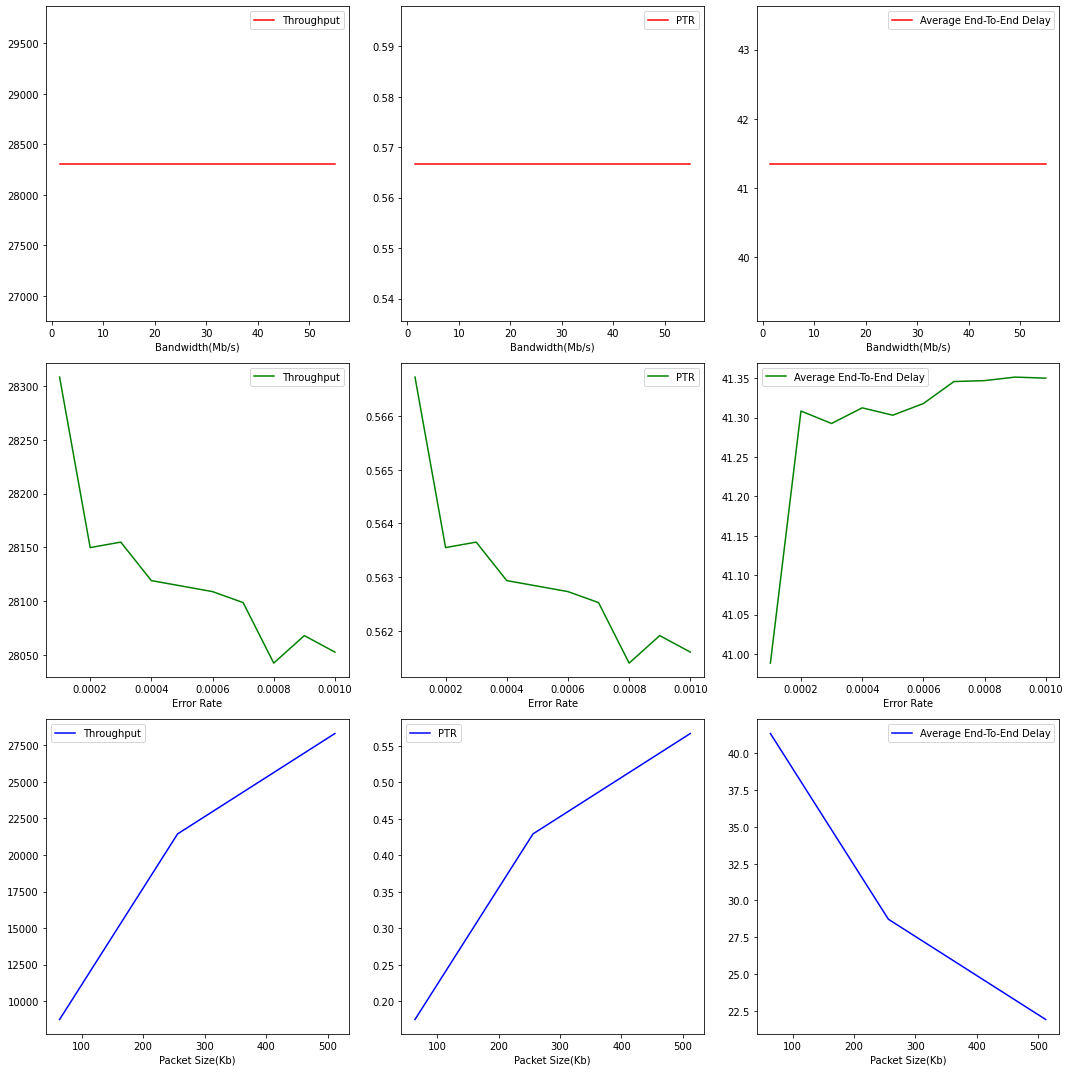

In [30]:
X = ['Bandwidth(Mb/s)', 'Error Rate', 'Packet Size(Kb)']
Y = ['Throughput', 'PTR', 'Average End-To-End Delay']

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15,15))
i,j = 0, 0
colors = ["r", "g", "b"]

for x in X:
    for y in Y:
        unindexed_results.groupby(by=x).max().plot(y=y, ax=axes[i, j], color=colors[i])
        j += 1
    j = 0
    i += 1

plt.tight_layout()
plt.show()

## Analysis of the plots

<h4>
    Based on the plots for bandwidth, the rates don't change.<br>
    This is because the rate of our packets and their size is small compared with the given bandwidths.<br>
    The error rate does have some effect on our calculated rates.<br>
    By increasing the error rate, throughput and PTR decrease. This is because the rate of packets that are successfully transfered is decreased.<br>
    Packet size has positive effect on the rates.<br>
    Obviously, increasing the size of our packets will decrease the number of dropped packets and eventually increase throughput which is the transfered bits to total time.<br>
    Note that incresaing the packet size too much will result in the decrease of the rates. If the size is too large, an error will cause a large amount of bits to be lost and this will significantly decrease throughput.
</h4>